## Yolov5 high resolution training

In [22]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from shutil import copyfile
from sklearn.model_selection import GroupKFold
import matplotlib.pyplot as plt

In [78]:
train = pd.read_csv('/home/ldp/competitions/dcic2022/ship_detect/data/train.csv', encoding = 'gb2312')
train['train'] = 1
# train['pos'] = train.annotations != '[]'
submit = pd.read_csv('/home/ldp/competitions/dcic2022/ship_detect/submission.csv',header=None)

In [79]:
submit.columns = ['文件名','坐标']

In [80]:
def get_ship_num(x):
    return len(x.split(';')) if type(x) != float else 0
submit['船数量'] = submit['坐标'].apply(get_ship_num)


In [ ]:
kf = GroupKFold(n_splits = 5) 
train = train.reset_index(drop=True)
train['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(kf.split(train, y = train.船数量.tolist(), groups=train.文件名)):
    train.loc[val_idx, 'fold'] = fold

train.head(5)

<AxesSubplot:>

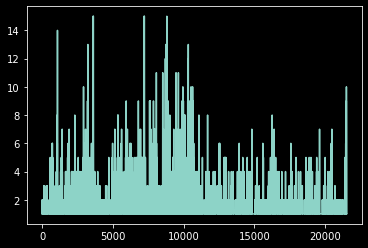

In [83]:
train.船数量.plot()

In [85]:
submit.iloc[:,0].values

array([    1,     5,     7, ..., 39614, 39615, 39616])

In [86]:
train.文件名.values

array([    2,     3,     4, ..., 39609, 39611, 39612])

In [87]:
all_idx = [0 for _ in range(max(list(submit.iloc[:,0].values)+list(train.文件名.values)))]

In [97]:
!mkdir -p ./yolo_data/fold_submit/images/val
!mkdir -p ./yolo_data/fold_submit/images/train

!mkdir -p ./yolo_data/fold_submit/labels/val
!mkdir -p ./yolo_data/fold_submit/labels/train

In [98]:
fold = '_submit'

annos = []
for i, x in train.iterrows():
    if x.fold == 0:
        mode = 'val'
        if x.船数量<=0: continue
        copyfile(f'/home/ldp/competitions/dcic2022/ship_detect/data/test_dataset/{str(x.文件名).zfill(5)}.jpg',
                f'./yolo_data/fold{fold}/images/{mode}/{str(x.文件名).zfill(5)}.jpg')
    else:
        # train
        mode = 'train'
        if x.船数量<=0: continue
        copyfile(f'/home/ldp/competitions/dcic2022/ship_detect/data/A/{str(x.文件名).zfill(5)}.jpg',
                f'./yolo_data/fold{fold}/images/{mode}/{str(x.文件名).zfill(5)}.jpg')
        # val


    r = ''
    anno = []
    for pos in x.坐标.split(';'):
        anno.append([eval(i) for i in pos.split(' ')])
    for an in anno:
#            annos.append(an)
        r += '0 {} {} {} {}\n'.format(an[0],an[1],an[2],an[3])
    with open(f'./yolo_data/fold{fold}/labels/{mode}/{str(x.文件名).zfill(5)}.txt', 'w') as fp:
        fp.write(r)

In [104]:
hyps = '''
# YOLOv5 by Ultralytics, GPL-3.0 license
# Hyperparameters for COCO training from scratch
# python train.py --batch 40 --cfg yolov5m.yaml --weights '' --data coco.yaml --img 640 --epochs 300
# See tutorials for hyperparameter evolution https://github.com/ultralytics/yolov5#tutorials

lr0: 0.01  # initial learning rate (SGD=1E-2, Adam=1E-3)
lrf: 0.1  # final OneCycleLR learning rate (lr0 * lrf)
momentum: 0.937  # SGD momentum/Adam beta1
weight_decay: 0.0005  # optimizer weight decay 5e-4
warmup_epochs: 3.0  # warmup epochs (fractions ok)
warmup_momentum: 0.8  # warmup initial momentum
warmup_bias_lr: 0.1  # warmup initial bias lr
box: 0.05  # box loss gain
cls: 0.5  # cls loss gain
cls_pw: 1.0  # cls BCELoss positive_weight
obj: 1.0  # obj loss gain (scale with pixels)
obj_pw: 1.0  # obj BCELoss positive_weight
iou_t: 0.20  # IoU training threshold
anchor_t: 4.0  # anchor-multiple threshold
# anchors: 3  # anchors per output layer (0 to ignore)
fl_gamma: 0.0  # focal loss gamma (efficientDet default gamma=1.5)
hsv_h: 0.015  # image HSV-Hue augmentation (fraction)
hsv_s: 0.2 # image HSV-Saturation augmentation (fraction)
hsv_v: 0.2  # image HSV-Value augmentation (fraction)
degrees: 0.0  # image rotation (+/- deg)
translate: 0.1  # image translation (+/- fraction)
scale: 0.35  # image scale (+/- gain)
shear: 0.0  # image shear (+/- deg)
perspective: 0.0  # image perspective (+/- fraction), range 0-0.001
flipud: 0.5  # image flip up-down (probability)
fliplr: 0.5  # image flip left-right (probability)
mosaic: 0.1  # image mosaic (probability)
mixup: 0.4  # image mixup (probability)
copy_paste: 0.0  # segment copy-paste (probability)
'''

In [111]:
data = '''
# Train/val/test sets as 1) dir: path/to/imgs, 2) file: path/to/imgs.txt, or 3) list: [path/to/imgs1, path/to/imgs2, ..]
path: ./yolo_data/fold_submit/  # dataset root dir
train: images/train  # train images (relative to 'path') 128 images
val: images/val  # val images (relative to 'path') 128 images
test:  # test images (optional)

# Classes
nc: 1  # number of classes
names: ['ship']  # class names


# Download script/URL (optional)
# download: https://ultralytics.com/assets/coco128.zip
'''

In [1]:
!git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...
fatal: unable to access 'https://github.com/ultralytics/yolov5.git/': Could not resolve host: github.com


In [114]:
with open('./yolov5/data/ship_f1_naive_3.yaml', 'w') as fp:
    fp.write(data)
with open('./yolov5/data/hyps/hyp.heavy.2.yaml', 'w') as fp:
    fp.write(hyps)

In [115]:
%cd yolov5

/home/ldp/competitions/dcic2022/ship_detect/yolov5


In [116]:
!ls data/

Argoverse.yaml	      hyps		  scripts		SKU-110K.yaml
coco128.yaml	      images		  ship_f1_naive_2.yaml	VisDrone.yaml
coco.yaml	      Objects365.yaml	  ship_f1_naive_3.yaml	VOC.yaml
GlobalWheat2020.yaml  reef_f1_naive.yaml  ship_f1_naive.yaml	xView.yaml


In [117]:
!python train.py --img 32 --batch 1024 --epochs 150 --data ship_f1_naive_3.yaml --weights yolov5l.pt --name 32_1024_uflip_vm5_f1 --hyp data/hyps/hyp.heavy.2.yaml

wandb: Currently logged in as: anony-moose-164537 (use `wandb login --relogin` to force relogin)
train: weights=yolov5l.pt, cfg=, data=ship_f1_naive_3.yaml, hyp=data/hyps/hyp.heavy.2.yaml, epochs=150, batch_size=128, imgsz=528, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=128_528_uflip_vm5_f1_naive3, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: skipping check (offline), for updates see https://github.com/ultralytics/yolov5
requirements: opencv-python>=4.1.2 not found and is required by YOLOv5, attempting auto-update...
requirements: 'pip install opencv-python>=4.1.2' skipped (offline)
requirements: pandas>=1.1.4 not found and is require

In [12]:
!ls

CONTRIBUTING.md  __pycache__  hubconf.py	setup.cfg	val.py
Dockerfile	 data	      models		train.py	yolov5s6.pt
LICENSE		 detect.py    requirements.txt	tutorial.ipynb
README.md	 export.py    runs		utils
